# Bayesian Neural Networks with Pyro

Code source:
- https://alsibahi.xyz/snippets/2019/06/15/pyro_mnist_bnn_kl.html
- [Pyro forum post](https://forum.pyro.ai/t/i-wrote-a-blog-post-about-hiddenlayer/1081)


In [51]:
# Import relevant packages
import torch
import torch.nn.functional as nnf
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
from torch.optim import SGD 
from torch.distributions import constraints
import torchvision as torchv
import torchvision.transforms as torchvt
from torchvision.datasets.mnist import MNIST
from torch import nn
from pyro.infer import SVI, TraceMeanField_ELBO
import pyro
from pyro import poutine
import pyro.optim as pyroopt
import pyro.distributions as dist
import pyro.contrib.bnn as bnn
import matplotlib.pyplot as plt
import seaborn as sns
from torch.distributions.utils import lazy_property
import math



In [58]:
print(pyro.__version__)

1.3.1


In [52]:
# Comment out if you want to run on the CPU
torch.set_default_tensor_type('torch.cuda.FloatTensor')

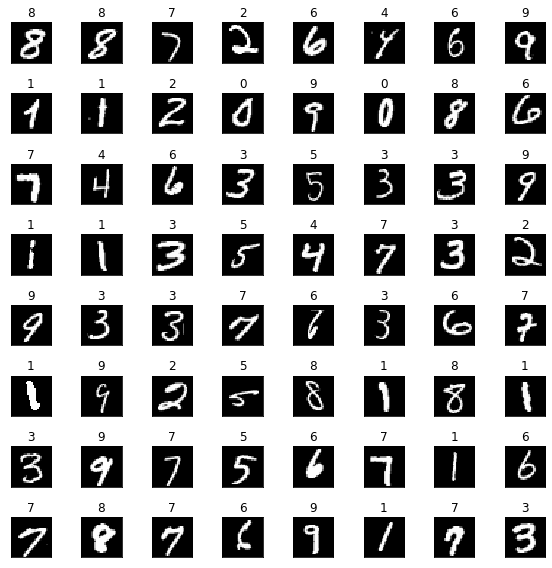

In [55]:
# Set download=True to get the images from the internet
tr = torchvt.Compose([
    torchvt.ToTensor()
])
mnist = MNIST(root='data', transform=tr, download=False)

train_set, test_set = random_split(mnist, lengths=(50_000, 10_000))

train_loader = DataLoader(train_set, batch_size=128)
test_loader = DataLoader(test_set)

images, labels = next(iter(train_loader))

fig, axes = plt.subplots(nrows=8, ncols=8)
for i, (image, label) in enumerate(zip(images, labels)):
    if i >= 64:
        break
    axes[i // 8][i % 8].imshow(images[i][0], cmap='gray')
    axes[i // 8][i % 8].set_title(f"{label}")
    axes[i // 8][i % 8].set_xticks([])
    axes[i // 8][i % 8].set_yticks([])
fig.set_size_inches(8, 8)
fig.tight_layout()


In [56]:
class BNN(nn.Module):
    def __init__(self, n_hidden=1024, n_classes=10):
        super(BNN, self).__init__()
        self.n_hidden = n_hidden
        self.n_classes = n_classes
       
    def model(self, images, labels=None, kl_factor=1.0): 
        images = images.view(-1, 784)
        n_images = images.size(0)
        # Set-up parameters for the distribution of weights for each layer `a<n>`
        a1_mean = torch.zeros(784, self.n_hidden)
        a1_scale = torch.ones(784, self.n_hidden) 
        a1_dropout = torch.tensor(0.25)
        a2_mean = torch.zeros(self.n_hidden + 1, self.n_classes)
        a2_scale = torch.ones(self.n_hidden + 1, self.n_hidden) 
        a2_dropout = torch.tensor(1.0)
        a3_mean = torch.zeros(self.n_hidden + 1, self.n_classes)
        a3_scale = torch.ones(self.n_hidden + 1, self.n_hidden) 
        a3_dropout = torch.tensor(1.0)
        a4_mean = torch.zeros(self.n_hidden + 1, self.n_classes)
        a4_scale = torch.ones(self.n_hidden + 1, self.n_classes)
        # Mark batched calculations to be conditionally independent given parameters using `plate`
        with pyro.plate('data', size=n_images):
            # Sample first hidden layer
            h1 = pyro.sample('h1', bnn.HiddenLayer(images, a1_mean, a1_dropout * a1_scale, 
                                                   non_linearity=nnf.leaky_relu,
                                                   KL_factor=kl_factor))
            # Sample second hidden layer
            h2 = pyro.sample('h2', bnn.HiddenLayer(h1, a2_mean, a2_dropout * a2_scale,
                                                   non_linearity=nnf.leaky_relu,
                                                   KL_factor=kl_factor))
            # Sample third hidden layer
            h3 = pyro.sample('h3', bnn.HiddenLayer(h2, a3_mean, a3_dropout * a3_scale,
                                                   non_linearity=nnf.leaky_relu,
                                                   KL_factor=kl_factor))
            # Sample output logits
            logits = pyro.sample('logits', bnn.HiddenLayer(h3, a4_mean, a4_scale,
                                                           non_linearity=lambda x: nnf.log_softmax(x, dim=-1),
                                                           KL_factor=kl_factor,
                                                           include_hidden_bias=False))
            # One-hot encode labels
            labels = nnf.one_hot(labels) if labels is not None else None
            # Condition on observed labels, so it calculates the log-likehood loss when training using VI
            return pyro.sample('label', dist.OneHotCategorical(logits=logits), obs=labels) 
    
    def guide(self, images, labels=None, kl_factor=1.0):
        images = images.view(-1, 784)
        n_images = images.size(0)
        # Set-up parameters to be optimized to approximate the true posterior
        # Mean parameters are randomly initialized to small values around 0, and scale parameters
        # are initialized to be 0.1 to be closer to the expected posterior value which we assume is stronger than
        # the prior scale of 1.
        # Scale parameters must be positive, so we constraint them to be larger than some epsilon value (0.01).
        # Variational dropout are initialized as in the prior model, and constrained to be between 0.1 and 1 (so dropout
        # rate is between 0.1 and 0.5) as suggested in the local reparametrization paper
        a1_mean = pyro.param('a1_mean', 0.01 * torch.randn(784, self.n_hidden))
        a1_scale = pyro.param('a1_scale', 0.1 * torch.ones(784, self.n_hidden),
                              constraint=constraints.greater_than(0.01))
        a1_dropout = pyro.param('a1_dropout', torch.tensor(0.25),
                                constraint=constraints.interval(0.1, 1.0))
        a2_mean = pyro.param('a2_mean', 0.01 * torch.randn(self.n_hidden + 1, self.n_hidden))
        a2_scale = pyro.param('a2_scale', 0.1 * torch.ones(self.n_hidden + 1, self.n_hidden),
                              constraint=constraints.greater_than(0.01)) 
        a2_dropout = pyro.param('a2_dropout', torch.tensor(1.0),
                                constraint=constraints.interval(0.1, 1.0))
        a3_mean = pyro.param('a3_mean', 0.01 * torch.randn(self.n_hidden + 1, self.n_hidden))
        a3_scale = pyro.param('a3_scale', 0.1 * torch.ones(self.n_hidden + 1, self.n_hidden),
                              constraint=constraints.greater_than(0.01))
        a3_dropout = pyro.param('a3_dropout', torch.tensor(1.0),
                                constraint=constraints.interval(0.1, 1.0))
        a4_mean = pyro.param('a4_mean', 0.01 * torch.randn(self.n_hidden + 1, self.n_classes))
        a4_scale = pyro.param('a4_scale', 0.1 * torch.ones(self.n_hidden + 1, self.n_classes),
                              constraint=constraints.greater_than(0.01))
        # Sample latent values using the variational parameters that are set-up above.
        # Notice how there is no conditioning on labels in the guide!
        with pyro.plate('data', size=n_images):
            h1 = pyro.sample('h1', bnn.HiddenLayer(images, a1_mean, a1_dropout * a1_scale, 
                                                   non_linearity=nnf.leaky_relu,
                                                   KL_factor=kl_factor))
            h2 = pyro.sample('h2', bnn.HiddenLayer(h1, a2_mean, a2_dropout * a2_scale,
                                                   non_linearity=nnf.leaky_relu,
                                                   KL_factor=kl_factor))
            h3 = pyro.sample('h3', bnn.HiddenLayer(h2, a3_mean, a3_dropout * a3_scale,
                                                   non_linearity=nnf.leaky_relu,
                                                   KL_factor=kl_factor))
            logits = pyro.sample('logits', bnn.HiddenLayer(h3, a4_mean, a4_scale,
                                                           non_linearity=lambda x: nnf.log_softmax(x, dim=-1),
                                                           KL_factor=kl_factor,
                                                           include_hidden_bias=False))
    
    def infer_parameters(self, loader, lr=0.01, momentum=0.9,
                         num_epochs=30):
        optim = pyroopt.SGD({'lr': lr, 'momentum': momentum, 'nesterov': True})
        elbo = TraceMeanField_ELBO()
        svi = SVI(self.model, self.guide, optim, elbo)
        kl_factor = loader.batch_size / len(loader.dataset)
        for i in range(num_epochs):
            total_loss = 0.0 
            total = 0.0
            correct = 0.0
            for images, labels in loader:
                loss = svi.step(images.cuda(), labels.cuda(), kl_factor=kl_factor)
                pred = self.forward(images.cuda(), n_samples=1).mean(0) 
                total_loss += loss / len(loader.dataset)
                total += labels.size(0)
                correct += (pred.argmax(-1) == labels.cuda()).sum().item()
                param_store = pyro.get_param_store()
            print(f"[Epoch {i + 1}] loss: {total_loss:.5E} accuracy: {correct / total * 100:.5f}")

    def forward(self, images, n_samples=10):
        res = []
        for i in range(n_samples):
            t = poutine.trace(self.guide).get_trace(images)
            res.append(t.nodes['logits']['value'])
        return torch.stack(res, dim=0) 

In [57]:
pyro.clear_param_store()
bayesnn = BNN()
bayesnn.infer_parameters(train_loader, num_epochs=30, lr=0.002)

AttributeError: 'HiddenLayer' object has no attribute '_batch_shape'